#Dataset

pip install prophet

In [258]:
# 라이브러리 임포트
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import autograd
from torch.utils import data
from torch.optim import Adam, SGD

import datetime as dt
from datetime import timedelta
import seaborn as sns
from prophet import Prophet


from plotly.offline import init_notebook_mode, iplot #plotly offline mode 
init_notebook_mode(connected = True)
import plotly.graph_objs as go #plotly graphical object

import matplotlib.pyplot as plt
DATASET_PATH = os.path.join('/workspace/Competition/TRAFFIC/01_DATA')

In [259]:
# 난수 생성기가 항상 일정한 값을 출력하게 하기 위해 seed 고정
random_seed = 2021
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

In [260]:
## EDA
train=pd.read_csv(os.path.join(DATASET_PATH, 'train.csv'))

val=pd.read_csv(os.path.join(DATASET_PATH, 'validate.csv'))

test=pd.read_csv(os.path.join(DATASET_PATH, 'test.csv'))



In [261]:
# 무시
pd.set_option('mode.chained_assignment',  None) # <==== 경고를 끈다

In [262]:
#index 날짜화 for feature
def datesetting(train): 
    train['날짜1']=train['날짜'].astype(str)
    train['시간1']=train['시간'].astype(str)
    train['date']=train['날짜']+train['시간']

    for i in range (0,len(train['날짜'])):
      a= train['날짜1'][i]
      train['날짜1'][i] =dt.datetime.strptime(a, '%Y%m%d')

    for i in range(0,len(train['시간'])):
      b= train['시간1'][i]
      train['시간1'][i]=dt.datetime.strptime(b, '%H')

    for i in range(0,len(train['날짜'])):
      train['date'][i]=train['날짜1'][i]+timedelta(hours=train['시간1'][i].hour)


#날짜 index 적용
datesetting(train)
datesetting(val)
datesetting(test)
train=train.drop(['날짜1','시간1'],axis=1)
val=val.drop(['날짜1','시간1'],axis=1)
test=test.drop(['날짜1','시간1'],axis=1)


# index 설정하여 각 기간별 columns 생성하는 함수(create_features)
train=train.set_index('date')
val=val.set_index('date')
test=test.set_index('date')
# test=test[test.index >= '2020-05-25']
df= pd.concat([train,val])

# Dataloader
* 한 칼럼에 대한 7일(168행) 데이터를 input_data, 뒤따르는 7일 데이터를 output_data로 반환합니다.
* 도로별 차이를 두지 않고 모든 도로를 동일한 타입의 데이터로 취급합니다.
* 모든 csv 파일의 마지막 168행은 예측해야하는 값이므로 input으로 들어가지 않습니다.

In [263]:
class CustomDataset(data.Dataset):      # torch.utils.data.Dataset 클래스의 상속 클래스 CustomDataset 클래스 생성. 상속 클래스 생성시 __init__, __getitem__, __len__함수는 기본적으로 정의해줘야 함.
                                        # CustomeDataset을 쓰는 이유 - 데이터의 크기가 클 때, 데이터 전체를 불러와서 계산하는 형태가 아닌 데이터 내에서 일부를 불러오면서 계산하기 위함.
    
    def __init__(self, root, seq_len, batch_size=64, phase='train'):      # 데이터 로드 단계에 사용될 여러 변수들을 'self.변수명'의 형태로 지정해두는 함수
        
        self.root = root      # CustomDataset 객체 생성 시 데이터 경로 앞부분(공통 부분)을 root로 입력받아 저장
        self.phase = phase      # CustomDataset 객체 생성 시 데이터 경로 뒷부분(train/validate/test)을 phase로 입력받아 저장
        self.label_path = os.path.join(self.root, self.phase + '.csv')      # 데이터 전체 경로 생성
        df = pd.read_csv(self.label_path)      # 생성한 데이터 전체 경로로부터 데이터 로드
        
        self.seq_len = seq_len * 24      # 일 단위 기간을 입력 받은 후 시간 단위 기간으로 변환하여 저장
        self.batch_size = batch_size
        self.labels = {}
        # self구조의 함수를 설정해서 자기 함수를 초기화 해서 다시 사용할 수 있도록 init처리
        
        timestamps = [(i, j) for (i, j) in zip(list(df['날짜']), list(df['시간']))]      # 날짜와 시간 정보가 튜플로 들어 있는 리스트 생성
        categories = df.columns.values.tolist()[2:]      # 도로명 column list 생성

        input_data = []
        output_data = []

        for t in range(len(timestamps)):
            temp_input_data = []
            temp_output_data = []
            for col in categories:
                road = df[col].tolist()
                inp = [float(i) for i in road[t:t+self.seq_len]]      # input 데이터 시계열 구간 설정
                outp = [float(j) for j in road[t+self.seq_len:t+2*self.seq_len]]      # output 데이터 시계열 구간 설정
                temp_input_data.append(inp) 
                temp_output_data.append(outp)
            input_data.append(temp_input_data)
            output_data.append(temp_output_data)
            
# input_data : [[첫번째 input 기간 동안의 첫번째 도로의 통행량 list, ..., 첫번째 input 기간 동안의 35번째 도로의 통행량 list], ...,
#               [마지막 input 기간 동안의 첫번째 도로의 통행량 list, ..., 마지막 input 기간 동안의 35번째 도로의 통행량 list]]
# output_data : [[첫번째 output 기간 동안의 첫번째 도로의 통행량 list, ..., 첫번째 output 기간 동안의 35번째 도로의 통행량 list], ...,
#                [마지막 output 기간 동안의 첫번째 도로의 통행량 list, ..., 마지막 output 기간 동안의 35번째 도로의 통행량 list]]
        
        self.labels['timestamp'] = timestamps
        self.labels['category'] = categories
        self.labels['input'] = input_data
        self.labels['output'] = output_data

    def __getitem__(self, index):      # index를 가지고 데이터를 하나씩 불러올 수 있게 하는 함수
    
#         데이터 내 index가 부여되는 형태

#                 | road_1    road_2    ...  road_35
#                -------------------------------------
#         time_1  | index_0   index_1   ...  index_34
#         time_2  | index_35  index_36  ...  index_69

        row = index // 35      # index를 35(도로수)로 나눈 몫  ex) 71//35 -> 2
        col = index % 35      # index를 35(도로수)로 나눈 나머지  ex) 71%35 -> 1

        timestamp = self.labels['timestamp'][row]      # (날짜, 시간) 튜플이 들어있는 list에서 row번째 시점에 해당하는 튜플 - timestamp
        category = self.labels['category'][col]      # 도로명 column list에서 col번째 도로에 해당하는 element - column
        
        input_data = torch.tensor(self.labels['input'][row][col])  
           # input_data list에서, row번째 시점의 col번째 도로 교통량 정보
        norm = input_data[-1]+1   # input_data list에서 마지막 도로 교통량 정보를 norm으로 담는다.
        
        input_data = input_data / norm
        
        if self.phase != 'test':
            output_data = torch.tensor(self.labels['output'][row][col]) / norm
        else:
            output_data = []
      
        return timestamp, category, (input_data, output_data)

    def __len__(self):      # getitem 함수를 통해 데이터를 불러오려면,전체 index 길이를 알아야 한다.
        return (len(self.labels['timestamp']) - (self.seq_len * 2) + 1) * 35      # 특정 시점이 아닌 특정 기간을 하나의 data 단위로 설정하면, 전체 샘플 수는 감소함을 반영 


def data_loader(root, phase='train', batch_size=64, seq_len=7, drop_last=False):
    if phase == 'train':
        shuffle = False
        
        ##shuffle이 False
    else:
        shuffle = False

    dataset = CustomDataset(root, seq_len, batch_size, phase)
    dataloader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)

    return dataloader

In [264]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [265]:
scaler = MinMaxScaler()

MinMax_train = scaler.fit_transform(train.drop(['날짜','시간'],axis=1))
MinMax_train = pd.DataFrame(MinMax_train, columns =train.drop(['날짜','시간'],axis = 1).columns)

In [266]:
train=train.reset_index()
MinMax_train[['날짜','시간']]=train[['날짜','시간']]
train=train.set_index('date')
MinMax_train

,10,100,101,120,121,140,150,160,200,201,...,1100,1200,1510,2510,3000,4510,5510,6000,날짜,시간
0,0.143505,0.095255,0.056923,0.044944,0.064563,0.036203,0.110488,0.115512,0.164181,0.056679,...,0.147451,0.200955,0.041218,0.083679,0.070693,0.102993,0.100476,0.102912,20200101,0
1,0.153955,0.094752,0.072751,0.047913,0.067084,0.042331,0.121947,0.116077,0.204678,0.058864,...,0.171998,0.249233,0.044969,0.082647,0.073906,0.091511,0.096896,0.108628,20200101,1
2,0.114827,0.073254,0.064750,0.040328,0.042446,0.037380,0.091851,0.077950,0.193241,0.055004,...,0.104216,0.154183,0.053836,0.070919,0.046404,0.069205,0.071883,0.091778,20200101,2
3,0.091864,0.068488,0.049489,0.036941,0.041511,0.032063,0.073020,0.064181,0.207016,0.048779,...,0.074424,0.089679,0.038695,0.063298,0.040733,0.065369,0.059730,0.099851,20200101,3
4,0.089804,0.087721,0.052454,0.032125,0.074809,0.037420,0.077776,0.095601,0.320524,0.037826,...,0.075898,0.083343,0.042270,0.053436,0.047160,0.077560,0.090772,0.151917,20200101,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274,0.537370,0.504387,0.219865,0.266796,0.409010,0.355087,0.510044,0.480195,0.539846,0.280405,...,0.334038,0.406115,0.325961,0.488414,0.357811,0.444970,0.505394,0.547040,20200517,19
3275,0.526383,0.455291,0.187643,0.226599,0.329119,0.292138,0.467470,0.434018,0.429357,0.252334,...,0.321823,0.419044,0.288774,0.452527,0.302712,0.394577,0.460078,0.486577,20200517,20
3276,0.527511,0.374054,0.137893,0.173583,0.232192,0.182394,0.443186,0.362494,0.299820,0.201670,...,0.297290,0.400119,0.224037,0.393951,0.231264,0.325872,0.368600,0.380089,20200517,21
3277,0.409322,0.246494,0.091761,0.105762,0.158196,0.110313,0.331153,0.248959,0.193654,0.135953,...,0.217150,0.314446,0.155165,0.262568,0.141291,0.197236,0.253757,0.240796,20200517,22


In [267]:
3279/24

136.625

#Initialisation

LSTM은 크게 3가지의 메인 파라미터를 가지고 있다.

- input_size : input x에서의 expected features의 수
- hidden_size : hidden state h에서의 features 수
- bias : defaults to true

#Forward method

- input : tensor의 input의 shape는 (batch, input_size)
- h_0 : initial hidden state를 담는 tensor(각 element의 배치마다) / shape (batch, hidden_size)
- c_0 : initial hidden state를 담는 tensor(각 element의 배치마다) / shape (batch, hidden_size)

여기서 LSTM의 Cells가 연결되기 위해선 outputs의 tensor shape이 (h_1, c_1)이 되어야한다.

Ex에서는 batch size가 64. n_samples = x.size(0)



## Model

In [268]:
from torch.autograd import Variable

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):  # init 함수는 2개의 선형레이어를 초기화 한다. 하나는 출력, 다른 하나는 상태 벡터 또는 히든 벡터를 계산한다.
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.i2h =  nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o =  nn.Linear(input_size + hidden_size, hidden_size)
    self.softmax = nn.LogSoftmax(dim=1)

    def forward(self,input, hidden):   #forward 함수는 입력 벡터와 히든 벡터를 cat함수로 결합해 출력벡터와 숨겨진 상태를 생성하는 두 선형 레이어를 통과시킨다. 
      combined = torch.cat((input, hidden), 1)
      hidden = self.i2h(combined)
      output = self.i2o(combined)
      output = self.softmax(output)   # 출력 layer에는 log_softmax함수를 적용.
      return output, hidden

    def initHidden(self):   # RNN을 처음 호출할 경우에 상태 벡터를 만드는 기능을 제공한다.
      return Variable(torch.zeros(1, self.hidden_size))

# torch.cat은 두 텐서를 결합하며, 두 번째 전달 인자인 dim은 결합방향을 설정했다. 예를 들어 input이 [[1,1,],[2,2,]]이고 hidden이 [[11,11],[22,22]]라면, torch.cat((input,hidden),1)의 결과는 [[1,1,1,11,11],[2,2,22,22]]이 된다.


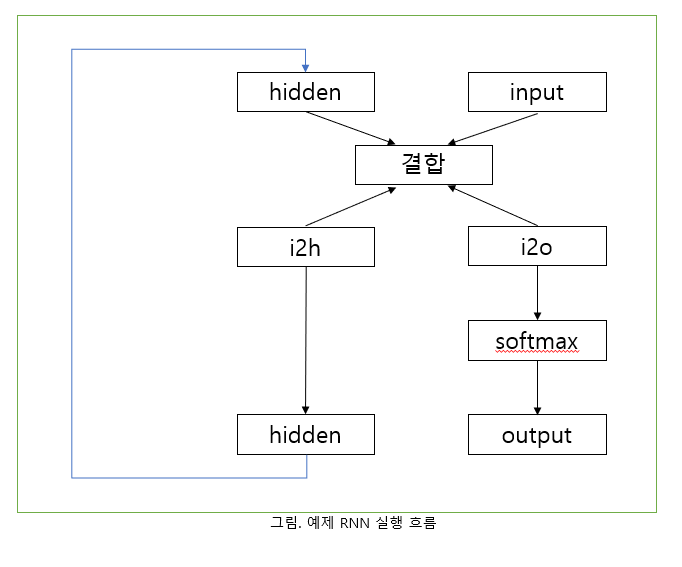

In [330]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class LSTMNet(nn.Module):      # torch.nn.Module 클래스의 상속 class LSTMNet class 생성. 상속 클래스 생성시 __init__, forward 함수는 기본적으로 정의해줘야 함.
    def __init__(self,
                 input_size=168,      # input 길이는 168시간(7일 X 24시간)
                 hidden_size=1024,
                 output_size=168,      # output 길이는 168시간(7일 X 24시간)
                 batch_size=64,
                 num_layers=3,
                 dropout=0,
                 batch_first=False):      # batch_first(default=False) : 배치 차원을 첫번째 차원으로 하여 데이터를 불러올 것인지 여부 RNN예시에서는 shuffle을 False로 바꾸고 batch_first를 True로 바꿈.

        super(LSTMNet, self).__init__()

        self.hidden_size = hidden_size
        
        ##### Layer 1
        self.lstm1 = nn.LSTM(input_size,
                             hidden_size,
                             dropout=0.2,
                             num_layers=num_layers)
        
        ##### Layer 2
        self.lstm2 = nn.LSTM(hidden_size, 
                             hidden_size,
                             dropout=0.2,
                             num_layers=num_layers)
        
        ##### Finalize
        self.linear = nn.Linear(hidden_size, 
                                output_size)
        
        self.activation = nn.ReLU()

        
    def forward(self, x):      # forward 함수를 직접 호출할 일은 없음. model = LSTMNet() 객체를 생성한 다음, 
                                           # predictions, (h2, c_2) = model(input_data, h_in, c_in) 형태로 return을 받으면 됨
        # h_in = nn.Parameter(h_in.type(dtype), requires_grad = True)
        # c_in = nn.Parameter(c_in.type(dtype), requires_grad = True)   

        lstm_out, (h_1, c_1) = self.lstm1(x)
        lstm_out = self.activation(lstm_out)


        # Layer2
        lstm_out, (h_2, c_2) = self.lstm2(lstm_out, (h_1, c_1))
        lstm_out = self.activation(lstm_out)
        

        # Final
        predictions = self.linear(lstm_out)
        
        
        return predictions

In [331]:
train[train.index>='2020-01-01 00:00:00']

,날짜,시간,10,100,101,120,121,140,150,160,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,20200101,0,83247,19128,2611,5161,1588,892,32263,1636,...,1311,3482,11299,7072,1176,3810,748,3920,2133,3799
2020-01-01 01:00:00,20200101,1,89309,19027,3337,5502,1650,1043,35609,1644,...,1162,3849,13180,8771,1283,3763,782,3483,2057,4010
2020-01-01 02:00:00,20200101,2,66611,14710,2970,4631,1044,921,26821,1104,...,768,2299,7986,5426,1536,3229,491,2634,1526,3388
2020-01-01 03:00:00,20200101,3,53290,13753,2270,4242,1021,790,21322,909,...,632,1716,5703,3156,1104,2882,431,2488,1268,3686
2020-01-01 04:00:00,20200101,4,52095,17615,2406,3689,1840,922,22711,1354,...,875,2421,5816,2933,1206,2433,499,2952,1927,5608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-17 19:00:00,20200517,19,311727,101285,10085,30637,10060,8749,148935,6801,...,6726,15431,25597,14292,9300,22238,3786,16936,10729,20194
2020-05-17 20:00:00,20200517,20,305354,91426,8607,26021,8095,7198,136503,6147,...,5501,15378,24661,14747,8239,20604,3203,15018,9767,17962
2020-05-17 21:00:00,20200517,21,306008,75113,6325,19933,5711,4494,129412,5134,...,4216,12558,22781,14081,6392,17937,2447,12403,7825,14031


In [332]:
# 결과 파일과 모델 가중치 파일 저장을 위해 log 디렉토리 생성. 중요한 파일이 덮어씌워지지 않도록 주의
os.makedirs('log', exist_ok=True)      # log 폴더 생성, 이미 생성되었을 시 추가로 생성하지 않도록 exist_ok=True


def save_model(model_name, model, optimizer):      # 모델 가중치 파일 저장 함수
    state = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, os.path.join('log', model_name + '.pth'))
    print('model saved\n')


def load_model(model_name, model, optimizer=None):      # 모델 가중치 파일 로드 함수
    state = torch.load(os.path.join(model_name))
    model.load_state_dict(state['model'])
    if optimizer is not None:
        optimizer.load_state_dict(state['optimizer'])
    print('model loaded')

## Hyperparameters

In [333]:
dtype = torch.float
num_epochs = 5
base_lr = 0.001
seq_len = 7

input_size = 168
hidden_size = 1008
output_size = input_size
batch_size = 64
num_layers = 6  #시간축 방향으로는 vanishing 문제 어느정도 해결 but 세로축으로는 여전히 존재

## Training Setting

In [334]:
# model
model = LSTMNet(input_size=input_size,
                hidden_size=hidden_size,
                output_size=output_size,
                batch_size=batch_size,
                num_layers=num_layers)

model = model.to(device)

# loss function
criterion = nn.MSELoss()      # 플랫폼 상 채점은 RMSE, 즉 MSE에 root를 씌운 값이기 때문에 사실상 평가지표와 같은 Loss입니다.

# optimizer
optimizer = Adam(model.parameters(), lr=base_lr, weight_decay=1e-4)      # optimizer로는 Adam이 가장 무난합니다. Adam을 쓰면 learning_rate를 따로 지정해주지 않아도 알아서 조정됩니다.

In [335]:
input_data.shape

torch.Size([1, 1, 168])

In [336]:
print(model)

LSTMNet(
  (lstm1): LSTM(168, 1008, num_layers=6, dropout=0.2)
  (lstm2): LSTM(1008, 1008, num_layers=6, dropout=0.2)
  (linear): Linear(in_features=1008, out_features=168, bias=True)
  (activation): ReLU()
)


In [337]:
input_data.unsqueeze(0).to(device).shape

torch.Size([1, 1, 1, 168])

In [338]:
# get data loader

train_dataloader = data_loader(root=DATASET_PATH,
                               phase='train',
                               batch_size=1,
                               seq_len=seq_len,
                               drop_last=True
                               )

validate_dataloader = data_loader(root=DATASET_PATH,
                                  phase='validate',
                                  batch_size=1,
                                  seq_len=seq_len,
                                  drop_last=True)

## Train

In [341]:
model(input_data.to(device))

tensor([[[ 0.0205,  0.0254,  0.0226,  0.0052,  0.0306, -0.0265, -0.0191,
           0.0015,  0.0181, -0.0165,  0.0189,  0.0065,  0.0270,  0.0156,
          -0.0028, -0.0196, -0.0167,  0.0101,  0.0086,  0.0066,  0.0009,
          -0.0178,  0.0255, -0.0055, -0.0016,  0.0211,  0.0043,  0.0223,
          -0.0302,  0.0179,  0.0046, -0.0222, -0.0083, -0.0287,  0.0247,
           0.0169, -0.0076, -0.0151,  0.0178,  0.0296,  0.0222,  0.0006,
           0.0045,  0.0315,  0.0172, -0.0198,  0.0170, -0.0027, -0.0242,
          -0.0171, -0.0199, -0.0161,  0.0091, -0.0306, -0.0196,  0.0307,
           0.0166,  0.0173,  0.0300, -0.0189, -0.0138,  0.0252,  0.0174,
          -0.0112,  0.0195,  0.0209, -0.0306, -0.0138,  0.0092,  0.0054,
           0.0175,  0.0210, -0.0254,  0.0236, -0.0280, -0.0029,  0.0139,
           0.0154, -0.0113,  0.0325, -0.0185,  0.0194,  0.0254,  0.0125,
          -0.0074, -0.0205,  0.0154,  0.0193, -0.0165,  0.0312, -0.0230,
           0.0243, -0.0289, -0.0276, -0.0220, -0.01

In [342]:
train_batch_loss = 0.0      # 400 batch마다 평균 training loss를 확인한 다음, train_batch_loss를 0으로 갱신해줄 것
train_epoch_loss = 0.0      # 1 epoch마다 평균 training loss를 확인한 다음, train_epoch_loss를 0으로 갱신해줄 것

valid_epoch_loss = 0.0      # 1 epoch마다 평균 validation loss를 확인한 다음, valid_epoch_loss를 0으로 갱신해줄 것
valid_min_epoch_loss = np.inf      # 초기 loss를 마이너스 무한대로 설정해두고, validation epoch loss가 낮아질 때마다 갱신해줄 것


for epoch in range(num_epochs):
 
    model.train()      # 모델을 train mode로 전환. train mode일 때만 적용되어야 하는 drop out 등이 적용될 수 있게 하기 위함 

    for iter_, sample in enumerate(train_dataloader):      # enumerate 함수를 통해 train_dataloader에서 'batch의 index'와 'batch'를 순서대로 호출

        _, _,(input_data, output_data) = sample      # train_dataloader에서 불러온 sample은 [[날짜, 시간], [도로], [[input_data],[output_data]]]로 구성됨.
                                                      # 학습에는 [[input_data], [output_data]]만 사용
        
        input_data = input_data.to(device)      #unsqueeze 차원 맞춰주는 것
        output_data = output_data.to(device)   
     
        pred = model(input_data)
        
        loss = criterion(pred, output_data)

        model.zero_grad()    # 파라미터 업데이트는 batch 단위로 이루어지고, 매 batch마다 gradient를 초기화해주어야 함 
        loss.backward()   # backpropagation
        
        optimizer.step()      # 파라미터 업데이트
        
        train_batch_loss += loss.item() #item은 tensor에서 스칼라 값을 가져오기위한 함수
        train_epoch_loss += loss.item()

        if iter_ % 400 == 399:      # 400개의 batch마다 training Loss 출력
            print(norm)             # norm 크기 출력
            print(train_batch_loss)   # train_batch 배치
            print('Train Epoch: {:2} | Batch: {:4} | Loss: {:1.2f}'.format(epoch, iter_+1, train_batch_loss/400))
            train_batch_loss = 0
            
    train_epoch_loss = 0.0      # training epoch마다 train_epoch_loss 새로 구해줄 것

    
    model.eval()      # 모델을 eval mode로 전환. eval mode에서 적용되면 안되는 drop out 등이 적용되지 않게 하기 위함

    with torch.no_grad():      # validation / test set에 대해서는 weight 및 bias의 update, 즉, gradient descent가 일어나지 않도록 no_grad()를 선언

        for iter_, sample in enumerate(validate_dataloader):      # enumerate 함수를 통해 validate_dataloader에서 'batch의 index'와 'batch'를 순서대로 호출

            _, _, (input_data, output_data) = sample      # validate_dataloader에서 불러온 sample은 [[날짜, 시간], [도로], [[input_data],[output_data]]]로 구성됨. validation에는 [[input_data], [output_data]]만 사용

            input_data = input_data.to(device)
            output_data = output_data.to(device)

            pred = model(input_data)
            loss = criterion(pred, output_data)
            valid_epoch_loss += loss.item()
        print(len(validate_dataloader))
        print('\nValid Epoch: {:2} | Loss: {:1.2f}'.format(epoch, valid_epoch_loss/len(validate_dataloader)))

        if valid_epoch_loss < valid_min_epoch_loss:
            save_model('best', model, optimizer)
            valid_min_epoch_loss = valid_epoch_loss

        valid_epoch_loss = 0.0

tensor([4609.])
6319.070092363283
Train Epoch:  0 | Batch:  400 | Loss: 15.80
tensor([4609.])
69.07558047445491
Train Epoch:  0 | Batch:  800 | Loss: 0.17
tensor([4609.])
4802.375710861757
Train Epoch:  0 | Batch: 1200 | Loss: 12.01
tensor([4609.])
29.6118335374631
Train Epoch:  0 | Batch: 1600 | Loss: 0.07
tensor([4609.])
3085.247596811503
Train Epoch:  0 | Batch: 2000 | Loss: 7.71
tensor([4609.])
14.792682860046625
Train Epoch:  0 | Batch: 2400 | Loss: 0.04
tensor([4609.])
1409.4825026122853
Train Epoch:  0 | Batch: 2800 | Loss: 3.52
tensor([4609.])
17.85138992033899
Train Epoch:  0 | Batch: 3200 | Loss: 0.04
tensor([4609.])
3101.059446081985
Train Epoch:  0 | Batch: 3600 | Loss: 7.75
tensor([4609.])
208.8867603421677
Train Epoch:  0 | Batch: 4000 | Loss: 0.52
tensor([4609.])
2192.695110869361
Train Epoch:  0 | Batch: 4400 | Loss: 5.48
tensor([4609.])
172.86042826855555
Train Epoch:  0 | Batch: 4800 | Loss: 0.43
tensor([4609.])
1934.299561649328
Train Epoch:  0 | Batch: 5200 | Loss: 

In [197]:
#마지막 아웃풋을 다음 인풋으로 받기 위해선 stateful=True로 성정해주어야하며, 이런 stateful 네트워크에선 고정된 배치 사이즈를 정해놓는 것이 좋습니다. 3D텐서는 (batch_size, timesteps, features)의 순서로 넣으면 됩니다. *배치 사이즈는 반드시 데이터 셋으로 나누어 떨어지는 숫자여야합니다. train, val, test에서 모두에 대해 나누어 떨어져야한다.

[[tensor([20200518]), tensor([0])],
 ('10',),
 [tensor([[0.5714, 0.3569, 0.2717, 0.2854, 0.5422, 1.3218, 2.1454, 2.4800, 2.2437,
           2.0888, 2.2029, 2.2296, 2.1082, 2.0861, 2.1808, 2.2540, 2.1194, 2.2104,
           2.1350, 1.6241, 1.3489, 1.2446, 0.9779, 0.6762, 0.4821, 0.3536, 0.2887,
           0.2989, 0.4253, 0.8657, 1.5450, 2.0152, 2.1208, 2.0729, 2.1758, 2.1673,
           2.0627, 2.1681, 2.1896, 2.2954, 2.3733, 2.4782, 2.2479, 1.7076, 1.4651,
           1.3372, 1.1099, 0.8108, 0.5525, 0.3947, 0.3288, 0.3255, 0.4891, 1.0615,
           1.7959, 2.2485, 2.2894, 2.2710, 2.3655, 2.3348, 2.2966, 2.2715, 2.2995,
           2.3754, 2.4849, 2.6436, 2.3693, 1.7643, 1.5113, 1.4088, 1.1209, 0.8541,
           0.5833, 0.3982, 0.3180, 0.3298, 0.4819, 1.0206, 1.7435, 2.2069, 2.3098,
           2.2420, 2.3930, 2.3667, 2.2472, 2.2970, 2.3280, 2.4211, 2.4911, 2.6195,
           2.4457, 1.9193, 1.6799, 1.5350, 1.2201, 0.8786, 0.5846, 0.4183, 0.3389,
           0.3384, 0.5014, 0.9991, 1.6906

In [191]:
!nvidia-smi

Tue Aug 30 10:19:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   39C    P0    36W / 250W |  12787MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000000:86:00.0 Off |                    0 |
| N/A   

## Inference

In [178]:
dtype = torch.float
seq_len = 7
input_size = seq_len * 24
hidden_size = 1024
output_size = input_size
batch_size = 1
num_layers = 6

In [144]:
test_dataloader = data_loader(root=DATASET_PATH,
                              phase='test',
                              batch_size=batch_size,
                                  seq_len=seq_len,
                                  drop_last=True)

In [145]:
model = LSTMNet(input_size=input_size,
                hidden_size=hidden_size,
                output_size=output_size,
                batch_size=batch_size,
                num_layers=num_layers)

# model
model_name = 'log/best.pth'

load_model(model_name, model)
model = model.to(device)

model loaded


In [200]:
print(input_size,'inputsize')
print(hidden_size,'hiddensize')
print(output_size,'outputsize')
print(batch_size,'batchsize')
print(num_layers,'numlayers')

168 inputsize
1024 hiddensize
168 outputsize
1 batchsize
6 numlayers


In [146]:
submission_file_path = os.path.join(DATASET_PATH, 'sample_submission.csv')
submission_table = pd.read_csv(submission_file_path)

In [192]:
submission_table

,timestamp,10,100,101,120,121,140,150,160,200,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200525_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20200525_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20200525_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20200525_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20200525_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,20200531_19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
164,20200531_20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
165,20200531_21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166,20200531_22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [148]:
print(hidden_size)
print(num_layers)
print(device)

1024
6
cuda


In [149]:
sample[2]

[tensor([[0.5071, 0.3927, 0.3320, 0.4083, 0.7932, 2.0482, 4.2580, 5.9013, 5.3964,
          4.7631, 4.8976, 4.8128, 4.2369, 4.2194, 4.5353, 4.6329, 4.9514, 5.3142,
          4.9761, 3.4443, 2.2957, 1.5971, 1.1510, 0.8125, 0.5372, 0.3617, 0.3695,
          0.3784, 0.7785, 1.6134, 3.3087, 5.3044, 5.1465, 4.9143, 5.0022, 4.8282,
          4.2536, 4.1690, 4.6828, 4.8937, 5.1057, 5.4680, 5.0473, 3.1668, 2.2784,
          1.5771, 1.1291, 0.8154, 0.4845, 0.3669, 0.3003, 0.4183, 0.7409, 1.7492,
          3.3771, 5.2348, 5.2690, 4.8190, 5.1623, 4.9883, 4.3187, 4.3296, 4.7125,
          4.8329, 5.1211, 5.3903, 3.5450, 3.4561, 2.2823, 1.7227, 1.2237, 0.8177,
          0.5689, 0.3278, 0.3567, 0.3882, 0.6392, 1.6971, 3.3070, 5.1911, 5.0501,
          4.7839, 5.1530, 4.7650, 4.2469, 4.4200, 4.7381, 4.7837, 5.2838, 5.7609,
          5.5491, 3.5689, 2.6900, 1.8447, 1.3552, 0.9356, 0.5138, 0.3680, 0.3450,
          0.4049, 0.5800, 0.0000, 2.7084, 4.4543, 4.7722, 4.2959, 4.6446, 4.5374,
          4.1914

In [150]:
pred

tensor([[[0.5441, 0.3794, 0.3728, 0.4428, 0.7970, 1.9142, 3.5975, 5.1070,
          4.5859, 3.5920, 3.6960, 3.8200, 3.5845, 3.7864, 4.1695, 4.0903,
          4.7572, 5.7183, 5.7366, 3.6190, 2.3775, 1.9218, 1.5206, 1.1080,
          0.7198, 0.4846, 0.3397, 0.3863, 0.7205, 1.7156, 3.4970, 5.4290,
          5.4632, 4.6036, 4.5190, 4.1889, 3.7299, 3.6632, 4.1288, 4.3790,
          4.9990, 5.7970, 5.8878, 3.6810, 2.5977, 2.0146, 1.6468, 1.1462,
          0.7446, 0.5317, 0.3813, 0.3851, 0.6939, 1.7266, 3.5750, 5.5264,
          5.5683, 4.6460, 4.2175, 3.9001, 3.3266, 3.5774, 4.0038, 4.2322,
          4.8410, 5.5570, 5.0113, 3.6510, 2.4199, 1.8146, 1.5054, 1.1151,
          0.7350, 0.5716, 0.4303, 0.3996, 0.6866, 1.6642, 3.5181, 5.5518,
          5.4681, 4.3882, 4.4155, 4.1012, 3.5503, 3.8297, 4.3237, 4.5132,
          4.8081, 5.6636, 5.5905, 3.6523, 2.4636, 1.7352, 1.4180, 1.1153,
          0.6901, 0.5334, 0.3749, 0.3620, 0.5912, 0.0172, 2.6701, 4.6328,
          4.6925, 3.9952, 3.7936, 3.74

In [151]:
sample[2]

[tensor([[0.5071, 0.3927, 0.3320, 0.4083, 0.7932, 2.0482, 4.2580, 5.9013, 5.3964,
          4.7631, 4.8976, 4.8128, 4.2369, 4.2194, 4.5353, 4.6329, 4.9514, 5.3142,
          4.9761, 3.4443, 2.2957, 1.5971, 1.1510, 0.8125, 0.5372, 0.3617, 0.3695,
          0.3784, 0.7785, 1.6134, 3.3087, 5.3044, 5.1465, 4.9143, 5.0022, 4.8282,
          4.2536, 4.1690, 4.6828, 4.8937, 5.1057, 5.4680, 5.0473, 3.1668, 2.2784,
          1.5771, 1.1291, 0.8154, 0.4845, 0.3669, 0.3003, 0.4183, 0.7409, 1.7492,
          3.3771, 5.2348, 5.2690, 4.8190, 5.1623, 4.9883, 4.3187, 4.3296, 4.7125,
          4.8329, 5.1211, 5.3903, 3.5450, 3.4561, 2.2823, 1.7227, 1.2237, 0.8177,
          0.5689, 0.3278, 0.3567, 0.3882, 0.6392, 1.6971, 3.3070, 5.1911, 5.0501,
          4.7839, 5.1530, 4.7650, 4.2469, 4.4200, 4.7381, 4.7837, 5.2838, 5.7609,
          5.5491, 3.5689, 2.6900, 1.8447, 1.3552, 0.9356, 0.5138, 0.3680, 0.3450,
          0.4049, 0.5800, 0.0000, 2.7084, 4.4543, 4.7722, 4.2959, 4.6446, 4.5374,
          4.1914

In [185]:
(h_in, c_in) = (torch.zeros(num_layers, 1, hidden_size, requires_grad=False).to(device),
                torch.zeros(num_layers, 1, hidden_size, requires_grad=False).to(device))

In [202]:
c_in.shape

torch.Size([6, 1, 1024])

In [213]:
h_in

tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')

In [154]:
sample

[[tensor([20200511]), tensor([0])],
 ('6000',),
 [tensor([[0.5071, 0.3927, 0.3320, 0.4083, 0.7932, 2.0482, 4.2580, 5.9013, 5.3964,
           4.7631, 4.8976, 4.8128, 4.2369, 4.2194, 4.5353, 4.6329, 4.9514, 5.3142,
           4.9761, 3.4443, 2.2957, 1.5971, 1.1510, 0.8125, 0.5372, 0.3617, 0.3695,
           0.3784, 0.7785, 1.6134, 3.3087, 5.3044, 5.1465, 4.9143, 5.0022, 4.8282,
           4.2536, 4.1690, 4.6828, 4.8937, 5.1057, 5.4680, 5.0473, 3.1668, 2.2784,
           1.5771, 1.1291, 0.8154, 0.4845, 0.3669, 0.3003, 0.4183, 0.7409, 1.7492,
           3.3771, 5.2348, 5.2690, 4.8190, 5.1623, 4.9883, 4.3187, 4.3296, 4.7125,
           4.8329, 5.1211, 5.3903, 3.5450, 3.4561, 2.2823, 1.7227, 1.2237, 0.8177,
           0.5689, 0.3278, 0.3567, 0.3882, 0.6392, 1.6971, 3.3070, 5.1911, 5.0501,
           4.7839, 5.1530, 4.7650, 4.2469, 4.4200, 4.7381, 4.7837, 5.2838, 5.7609,
           5.5491, 3.5689, 2.6900, 1.8447, 1.3552, 0.9356, 0.5138, 0.3680, 0.3450,
           0.4049, 0.5800, 0.0000, 2.70

In [155]:
model

LSTMNet(
  (lstm1): LSTM(168, 1024, num_layers=6, dropout=0.2)
  (lstm2): LSTM(1024, 1024, num_layers=6, dropout=0.2)
  (linear): Linear(in_features=1024, out_features=168, bias=True)
  (activation): ReLU()
)

In [205]:
input_data.unsqueeze(0).to(device).shape

torch.Size([1, 1, 1, 168])

In [214]:
model(input_data)

tensor([[[5.0115e-01, 4.0654e-01, 3.3562e-01, 3.3501e-01, 6.0530e-01,
          1.7838e+00, 3.4000e+00, 4.6070e+00, 4.1054e+00, 3.5706e+00,
          3.9485e+00, 4.0148e+00, 3.6865e+00, 3.8148e+00, 4.0195e+00,
          3.8480e+00, 3.9731e+00, 4.2251e+00, 4.1114e+00, 3.3840e+00,
          2.7890e+00, 2.1829e+00, 1.5696e+00, 1.0544e+00, 6.5339e-01,
          4.3450e-01, 3.2338e-01, 3.2425e-01, 5.2340e-01, 1.4407e+00,
          2.8307e+00, 3.9188e+00, 3.9647e+00, 3.7437e+00, 4.0676e+00,
          4.0433e+00, 3.7248e+00, 3.7127e+00, 3.9253e+00, 3.8562e+00,
          3.9897e+00, 4.3547e+00, 4.3503e+00, 3.5508e+00, 2.8340e+00,
          2.2891e+00, 1.6891e+00, 1.0966e+00, 6.8289e-01, 4.5547e-01,
          3.3967e-01, 3.1271e-01, 5.2808e-01, 1.4480e+00, 2.7657e+00,
          3.8765e+00, 3.9229e+00, 3.7141e+00, 4.0341e+00, 3.9140e+00,
          3.4911e+00, 3.7501e+00, 4.0235e+00, 3.9476e+00, 4.0857e+00,
          4.3532e+00, 3.7619e+00, 3.4212e+00, 2.6421e+00, 2.2337e+00,
          1.6395e+00

In [ ]:
(h_in, c_in) = (torch.zeros(num_layers, 1, hidden_size, requires_grad=False).to(device),
                torch.zeros(num_layers, 1, hidden_size, requires_grad=False).to(device))

for iter_, sample in enumerate(test_dataloader):

    timestamp, category, (input_data, output_data) = sample
    input_data = input_data.unsqueeze(0).to(device)
    pred = model(input_data,category)

    for i, (t, h) in enumerate(zip(timestamp[0], timestamp[1])):
        for cat, row in zip(category, pred[0]):
            cat = f'{cat}'
            submission_table[cat] = row.tolist()

In [ ]:
submission_table

In [221]:
submission_table.iloc[:,1:]=submission_table.iloc[:,1:]*4609

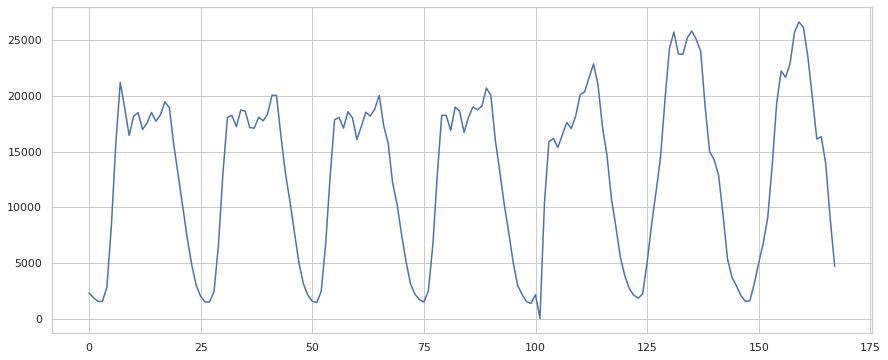

In [227]:
plt.plot(submission_table['10'])

In [228]:
submission_table

,timestamp,10,100,101,120,121,140,150,160,200,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200525_0,2309.808097,2309.632828,2309.599861,2309.607279,2309.569642,2309.587774,2309.741616,2309.659200,2309.653157,...,2309.572390,2309.653157,2309.636399,2309.720188,2309.650959,2309.657277,2309.554808,2309.600960,2309.600136,2309.606180
1,20200525_1,1873.756900,1873.576136,1873.541796,1873.550312,1873.512676,1873.530807,1873.687671,1873.603333,1873.596877,...,1873.516110,1873.596877,1873.579982,1873.665694,1873.594542,1873.601272,1873.497566,1873.543994,1873.543170,1873.549076
2,20200525_2,1546.873065,1546.614830,1546.566343,1546.577331,1546.523899,1546.549722,1546.774304,1546.652879,1546.644637,...,1546.527745,1546.644363,1546.619363,1546.742299,1546.641341,1546.650681,1546.502471,1546.568678,1546.567304,1546.576370
3,20200525_3,1544.068471,1543.540326,1543.441153,1543.464367,1543.354479,1543.408874,1543.866828,1543.619994,1543.601313,...,1543.363408,1543.601039,1543.551177,1543.802682,1543.595544,1543.613676,1543.312036,1543.446373,1543.444724,1543.462444
4,20200525_4,2789.849720,2788.958261,2788.789035,2788.828869,2788.641236,2788.733267,2789.510444,2789.092323,2789.061280,...,2788.657170,2789.061280,2788.975293,2789.401106,2789.051115,2789.082159,2788.568711,2788.798375,2788.793980,2788.823649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,20200531_19,16132.329648,16132.713154,16132.788976,16132.770295,16132.851612,16132.812052,16132.473600,16132.656013,16132.671397,...,16132.845018,16132.669199,16132.707659,16132.521950,16132.673594,16132.659309,16132.885677,16132.782383,16132.783482,16132.771394
164,20200531_20,16351.644566,16352.252242,16352.372019,16352.343448,16352.473115,16352.410479,16351.875329,16352.161035,16352.183013,...,16352.464324,16352.183013,16352.242352,16351.947854,16352.189606,16352.167629,16352.524762,16352.364326,16352.367623,16352.346745
165,20200531_21,13912.106478,13912.654815,13912.759207,13912.736131,13912.850414,13912.795470,13912.313066,13912.572399,13912.591080,...,13912.842722,13912.591080,13912.642727,13912.381196,13912.595476,13912.576795,13912.896566,13912.753713,13912.755911,13912.737230
166,20200531_22,8981.435551,8981.717411,8981.771805,8981.759168,8981.820156,8981.789937,8981.541042,8981.674555,8981.684445,...,8981.814112,8981.684445,8981.711367,8981.576756,8981.688291,8981.678401,8981.843232,8981.768509,8981.770707,8981.760817


In [201]:
h_in

tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')

out_

In [ ]:
submission_table.to_csv('prediction.csv', index=False)